# RNN stock price predictor

Using Recurrent neural network (RNN) and Long short-term memory (LSTM) algorithm, one of deep learning technique, we'll predict selected ticker's future price. 

Note : This is just a basic code, hence it's not suitable to apply in real life market, and any investment should be your own decision also risk you take.





## Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. In RNN, neuron is called cell, information of previously trained cell is used for next cell, hence it is suitable to process sequential data.

[image : RNN]

## Long short-term memory

RNN can store short-term memory, to find correlations of data, it needs long term memory, LSTM is used to support 
this.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


## Stock price predictor


### data cleansing

In [72]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
yf.pdr_override()
import matplotlib.pyplot as plt

    
def get_tickers(tickers, date_from):
    x = pdr.get_data_yahoo(tickers, start=date_from)
    df = pd.DataFrame(x[['Open', 'High', 'Low', 'Volume', 'Adj Close']])
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.rename(columns={'Adj Close' : 'Close'}, inplace=True)
    return df

def Normalizer(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data, 0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [73]:
tickers = ['AAPL']
df = get_tickers(tickers, '2000-01-04')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
Date,,,,,
2000-01-03,0.936384,1.004464,0.907924,535796800,0.859423
2000-01-04,0.966518,0.987723,0.903460,512377600,0.786965
2000-01-05,0.926339,0.987165,0.919643,778321600,0.798481
2000-01-06,0.947545,0.955357,0.848214,767972800,0.729382
2000-01-07,0.861607,0.901786,0.852679,460734400,0.763932
...,...,...,...,...,...
2021-05-24,126.010002,127.940002,125.940002,63092900,127.099998
2021-05-25,127.820000,128.320007,126.320000,72009500,126.900002
2021-05-26,126.959999,127.389999,126.419998,56575900,126.849998


In [74]:
dfx = Normalizer(df)
dfy = dfx[['Close']]


x = dfx.values.tolist()
y = dfy.values.tolist()

In [75]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5386 entries, 2000-01-03 to 2021-05-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5386 non-null   float64
 1   High    5386 non-null   float64
 2   Low     5386 non-null   float64
 3   Volume  5386 non-null   float64
 4   Close   5386 non-null   float64
dtypes: float64(5)
memory usage: 252.5 KB


In [76]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5386 entries, 2000-01-03 to 2021-05-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5386 non-null   float64
dtypes: float64(1)
memory usage: 84.2 KB


In [77]:
data_x = []
data_y = []
window_size = 20
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # not including next day close (i+window_size)
    _y = y[i + window_size] # Next day close
    data_x.append(_x)
    data_y.append(_y)

Run `print(_x, "->", _y)` to see _x values added to data_x and _y

In [78]:
print(_x, "->", _y)

[[0.9175547964307232, 0.92040287303561, 0.927024374727454, 0.009532692030105303, 0.919531830888699], [0.919368272452664, 0.9239237157080603, 0.9324089513809773, 0.004848772892050132, 0.9270976992944958], [0.9134395394400335, 0.9061127223623834, 0.8960627616704036, 0.013305431824181426, 0.8942418305138101], [0.8995591413912367, 0.8989330432435207, 0.9050607679636836, 0.0060497263942428355, 0.8959932940354725], [0.8904218361834393, 0.894100627685878, 0.8991093226434518, 0.00525422914222081, 0.9074823143785697], [0.9110680462349814, 0.9045248459129903, 0.9157591099850063, 0.00535777409666103, 0.9123243502316951], [0.901023949800766, 0.8926508503492057, 0.8968421182487007, 0.006601085666950878, 0.8887457664653976], [0.8598013483648804, 0.8700764910022464, 0.8682186289809585, 0.011758231254949677, 0.8821494295419565], [0.8591038534937149, 0.8588238361069469, 0.8645344421098943, 0.009865799562109418, 0.8601146863977368], [0.8673344206905419, 0.8692481070034387, 0.878775348430833, 0.009010917

Past 10 days, given data, latest close is 0.8726370803053053, next day close is 0.8677396475977315

### Prepare train / test dataset

In [79]:
# train dataset
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test dataset
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### Build model

In [80]:
model = keras.Sequential()
model.add(layers.LSTM(units=10, activation='relu',
                      return_sequences=True, input_shape=(window_size, 5)))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(units=10, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=1))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 10)            640       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [81]:
model.compile(optimizer='RMSprop', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, batch_size=30)
pred_y = model.predict(test_x)

Epoch 1/20
126/126 [==============================] - 5s 16ms/step - loss: 4.6710e-04 - accuracy: 2.6624e-04
Epoch 2/20
126/126 [==============================] - 2s 15ms/step - loss: 1.3531e-04 - accuracy: 2.6624e-04
Epoch 3/20
126/126 [==============================] - 2s 16ms/step - loss: 1.0652e-04 - accuracy: 2.6624e-04
Epoch 4/20
126/126 [==============================] - 2s 16ms/step - loss: 1.1145e-04 - accuracy: 2.6624e-04
Epoch 5/20
126/126 [==============================] - 3s 21ms/step - loss: 1.0220e-04 - accuracy: 2.6624e-04
Epoch 6/20
126/126 [==============================] - 3s 21ms/step - loss: 9.8137e-05 - accuracy: 2.6624e-04
Epoch 7/20
126/126 [==============================] - 2s 16ms/step - loss: 1.0391e-04 - accuracy: 2.6624e-04
Epoch 8/20
126/126 [==============================] - 2s 16ms/step - loss: 9.7792e-05 - accuracy: 2.6624e-04
Epoch 9/20
126/126 [==============================] - 2s 18ms/step - loss: 9.5982e-05 - accuracy: 2.6624e-04
Epoch 10/20
126/126

### Compare prediction to real

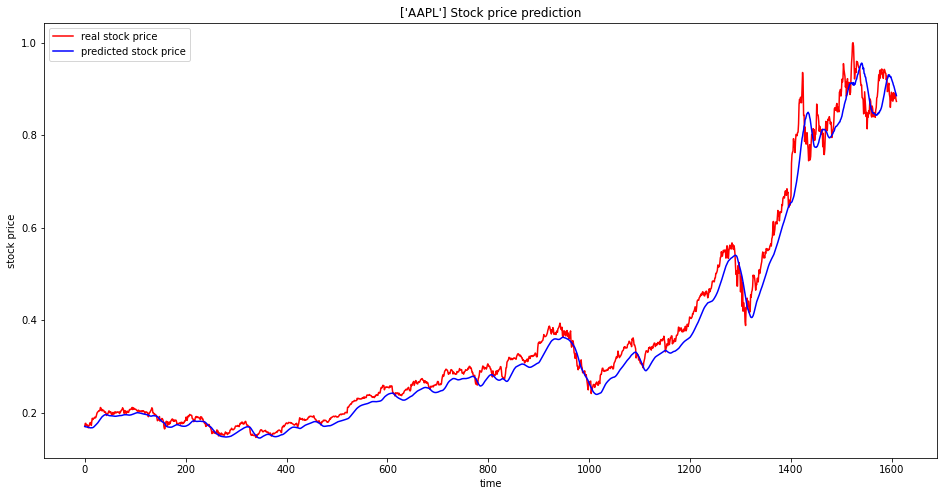

In [84]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y, c='blue', label='predicted stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### Predict tomorrw's close price

In [83]:
print(f'{tickers} tomorrow price : {df.Close[-1]*pred_y[-1]/dfy.Close[-1]}')

['AAPL'] tomorrow price : [126.392975]
